# Search for Cannabis in New NAIP Imagery (Bounding Box)

This notebook loads a trained segmentation model, downloads NAIP imagery for a user-specified bounding box, and searches for signs of cannabis.

In [2]:
import os
import planetary_computer
import pystac_client
import requests

## 1. Load Trained Segmentation Model
Load your trained model checkpoint from cannabis-segmentation-torchgeo.ipynb.

In [3]:
import segmentation_models_pytorch as smp
import torch

model = smp.DeepLabV3Plus(
    encoder_name="resnext50_32x4d",
    encoder_weights='imagenet',
    in_channels=5,
    classes=1
)

# Try MPS (Apple Silicon GPU), then CUDA (NVIDIA GPU), then CPU
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")

model = model.to(device)
model.load_state_dict(torch.load("../models/cannabis-segmentation-model.pth", map_location=device))
model.eval()
pass

Using device: mps


/var/folders/56/gwh1m3s973l4jc97_wdr2qqw0000gn/T/ipykernel_2732/2573365304.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../models/c

## 2. Specify Bounding Box
Enter the bounding box coordinates (min lon, min lat, max lon, max lat).

In [4]:
# --- User Input for Bounding Box ---
# bbox = [-120.72638195050153, 38.04185830635333, -120.63604314014556, 38.1207676113505]
# bbox = [-120.56802294590112,38.307368125981206,-120.47440785318257,38.36284893862011] # West Point
bbox = [-120.6419,38.1827,-120.44,38.3191] # West Point, south and larger
# bbox = [-120.68026045937673,38.075364038625466,-120.67004423250212,38.084287726674845] # Pool Station Rd
print('Using bounding box:', bbox)

Using bounding box: [-120.6419, 38.1827, -120.44, 38.3191]


## 3. Download NAIP Imagery for Bounding Box
Use Planetary Computer STAC API to search and download NAIP imagery.

In [5]:
# --- Download NAIP Imagery ---
naip_root = '../data-to-import/microsoft/naip/calaveras-county-pool-station-rd-inference-set'
time_range = '2016-01-01/2016-12-31'  # or update as needed
catalog = pystac_client.Client.open('https://planetarycomputer.microsoft.com/api/stac/v1')
search = catalog.search(collections=['naip'], bbox=bbox, datetime=time_range)
items = search.item_collection()
print(f'Found {len(items)} NAIP items for bbox')

# Download imagery
for item in items:
    asset = item.assets['image']
    signed_href = planetary_computer.sign(asset.href)
    out_path = os.path.join(naip_root, os.path.basename(asset.href))
    if not os.path.exists(out_path):
        print(f'Downloading {out_path}')
        r = requests.get(signed_href, stream=True)
        with open(out_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    else:
        print(f'Skipping {out_path} - already exists')


Found 19 NAIP items for bbox
Skipping ../data-to-import/microsoft/naip/calaveras-county-pool-station-rd-inference-set/m_3812053_sw_10_h_20160620.tif - already exists
Skipping ../data-to-import/microsoft/naip/calaveras-county-pool-station-rd-inference-set/m_3812053_nw_10_h_20160620.tif - already exists
Skipping ../data-to-import/microsoft/naip/calaveras-county-pool-station-rd-inference-set/m_3812053_ne_10_h_20160620.tif - already exists
Skipping ../data-to-import/microsoft/naip/calaveras-county-pool-station-rd-inference-set/m_3812052_sw_10_h_20160620.tif - already exists
Skipping ../data-to-import/microsoft/naip/calaveras-county-pool-station-rd-inference-set/m_3812052_se_10_h_20160620.tif - already exists
Skipping ../data-to-import/microsoft/naip/calaveras-county-pool-station-rd-inference-set/m_3812052_nw_10_h_20160620.tif - already exists
Skipping ../data-to-import/microsoft/naip/calaveras-county-pool-station-rd-inference-set/m_3812052_ne_10_h_20160620.tif - already exists
Skipping ../

## 4. Preprocess Imagery for Model Inference
Prepare the downloaded NAIP imagery as needed by your model (tiling, normalization, etc).

In [6]:
from torchgeo.datasets import RasterDataset
import rasterio
import re
from datetime import datetime
from pathlib import Path
from rtree import index as rindex
from rasterio.windows import Window
from torchgeo.datasets import BoundingBox

class MicrosoftNaip(RasterDataset):
    def __init__(self, naip_root, transforms=None):
        self.naip_root = Path(naip_root)
        self.filename_glob = "m_*.tif"
        self.filename_regex = r"^.*_.*" # (?P<date>\d{8})" # disable dates for now
        self.date_format = "%Y%m%d"
        self.is_image = True
        self.separate_files = False
        self.all_bands = ("R", "G", "B", "NIR")
        self.rgb_bands = ("R", "G", "B",)
        self.transforms = transforms

        # Build a mapping from ann_path → image_path
        self.image_paths = {}
        for img_path in self.naip_root.glob(self.filename_glob):
            self.image_paths[img_path.stem] = img_path

        super().__init__(paths=self.image_paths.values(), transforms=transforms)

        # set the dates
        dates = []
        for fname in self.image_paths.values():
            match = re.match(r"^.*_(\d{8})", fname.name)
            if match:
                date = datetime.strptime(match.group(1), "%Y%m%d")
                dates.append(date.timestamp())
        if dates:
            self.mint = min(dates)
            self.maxt = max(dates)
        else:
            self.mint = 0
            self.maxt = 9223372036854775807

    def __len__(self):
        return len(self.image_paths)

In [7]:
# Define the sampler with explicit Unit type
from torchgeo.samplers import Units, GridGeoSampler
from torch.utils.data import DataLoader
import pyproj
import numpy as np

dataset = MicrosoftNaip(naip_root=naip_root)
print(dataset)

# Convert bbox (lon/lat) to projected coordinates for roi BoundingBox
import pyproj
import numpy as np

# Get the CRS of the NAIP imagery from the first file
naip_files = list(Path(naip_root).glob("*.tif"))
if naip_files:
    with rasterio.open(naip_files[0]) as src:
        dst_crs = src.crs
        print(f"NAIP CRS: {dst_crs}")

    # Define the coordinate transformations
    wgs84 = pyproj.CRS.from_epsg(4326)  # WGS84 lat/lon
    transformer = pyproj.Transformer.from_crs(wgs84, dst_crs, always_xy=True)
    
    # Convert the bbox coordinates
    # bbox format is [minx, miny, maxx, maxy] = [west, south, east, north]
    west, south, east, north = bbox
    minx, miny = transformer.transform(west, south)
    maxx, maxy = transformer.transform(east, north)
    
    print(f"Converted coordinates:")
    print(f"minx={minx}, miny={miny}, maxx={maxx}, maxy={maxy}")
    
    # Create the roi BoundingBox with the converted coordinates
    roi = BoundingBox(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        mint=dataset.mint,
        maxt=dataset.maxt,
    )
    
    print(f"New ROI: {roi}")
else:
    print("No NAIP files found to determine projection")

# Define a sampler
tile_size = 256  # Define your tile size
sampler = GridGeoSampler(
    roi=roi,
    dataset=dataset, 
    size=tile_size,
    stride=tile_size
)

def custom_collate_fn(batch):
    """Custom collate function that handles geospatial objects"""
    # Extract items that can be batched normally
    images = []
    filenames = []
    
    for item in batch:
        if "image" in item:
            images.append(item["image"])
        if "filename" in item:
            filenames.append(item["filename"])
    
    # Return a new dictionary with properly batched tensors
    result = {}
    if images:
        result["image"] = torch.stack(images)
    if filenames:
        result["filename"] = filenames
    return result

# Use the custom collate function with DataLoader
dataloader = DataLoader(
    dataset, 
    batch_size=128, 
    sampler=sampler,
    collate_fn=custom_collate_fn
)

MicrosoftNaip Dataset
    type: GeoDataset
    bbox: BoundingBox(minx=701850.0, maxx=730050.0, miny=4215120.0, maxy=4250838.0, mint=0.0, maxt=9.223372036854776e+18)
    size: 20
NAIP CRS: EPSG:26910
Converted coordinates:
minx=706534.0705163355, miny=4228714.418392931, maxx=723801.1314321639, maxy=4244322.009751943
New ROI: BoundingBox(minx=706534.0705163355, maxx=723801.1314321639, miny=4228714.418392931, maxy=4244322.009751943, mint=1466406000.0, maxt=1466406000.0)


## 5. Run Model Inference
Apply the segmentation model to the preprocessed imagery.

In [8]:
import segmentation_models_pytorch as smp

model = smp.DeepLabV3Plus(
    encoder_name="resnext50_32x4d",
    encoder_weights="imagenet",
    in_channels=5,
    classes=1
)

# Try MPS (Apple Silicon GPU), then CUDA (NVIDIA GPU), then CPU
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")

model = model.to(device)
model.load_state_dict(torch.load("../models/cannabis-segmentation-model.pth", map_location=device))
model.eval()

Using device: mps


/var/folders/56/gwh1m3s973l4jc97_wdr2qqw0000gn/T/ipykernel_2732/2209156107.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../models/c

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downs

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def enhance_contrast(img, low_percentile=2, high_percentile=98):
    """Enhance contrast using percentile stretching - better for aerial imagery."""
    if img.ndim == 3:  # Handle multi-channel images
        out = np.zeros_like(img, dtype=float)
        for i in range(img.shape[-1]):
            channel = img[..., i]
            p_low, p_high = np.percentile(channel, (low_percentile, high_percentile))
            # Avoid division by zero
            if p_high - p_low > 1e-6:
                out[..., i] = np.clip((channel - p_low) / (p_high - p_low), 0, 1)
            else:
                out[..., i] = channel  # If constant channel, keep as is
        return out
    else:  # Handle single-channel images
        p_low, p_high = np.percentile(img, (low_percentile, high_percentile))
        if p_high - p_low > 1e-6:
            return np.clip((img - p_low) / (p_high - p_low), 0, 1)
        else:
            return img

def unnormalize(img, mean, std):
    """Unnormalize a CHW or HWC image array."""
    img = img.copy()
    mean = np.array(mean)
    std = np.array(std)
    
    # Handle CHW format (C, H, W)
    if img.shape[0] in [3, 4, 5] and len(img.shape) == 3:
        # CHW format - unnormalize then transpose
        img = img * std[:, None, None] + mean[:, None, None]
        img = img.transpose(1, 2, 0)  # Now HWC
    elif img.shape[-1] in [3, 4, 5]:  # Already HWC
        img = img * std + mean
    
    return np.clip(img, 0, 1)

def show_batch(images, preds=None, mean=None, std=None, bands=(0,1,2), enhance=True, figsize=(16, 8)):
    """
    Visualize a batch of images, masks, and (optionally) predictions.
    
    Parameters:
    -----------
    images: numpy array (B, C, H, W) or (B, H, W, C)
        Batch of images to visualize
    preds: optional, numpy array
        Predicted masks/labels
    mean, std: optional, arrays of length C
        Normalization parameters for unnormalizing
    bands: tuple
        Which bands to display as RGB (default: 0,1,2)
    enhance: bool
        Whether to apply contrast enhancement (recommended for aerial imagery)
    figsize: tuple
        Figure size in inches (width, height). Larger = higher display resolution
    """
    batch_size = images.shape[0]
    for i in range(batch_size):
        img = images[i]
        
        # Handle unnormalization if needed
        if mean is not None and std is not None:
            img_vis = unnormalize(img, mean, std)
        else:
            img_vis = img.copy()
            # Convert CHW to HWC if needed
            if len(img_vis.shape) == 3 and img_vis.shape[0] in [3, 4, 5]:
                img_vis = img_vis.transpose(1, 2, 0)
        
        # Select the specified bands
        if img_vis.shape[-1] >= max(bands) + 1:
            img_vis = img_vis[..., list(bands)]
        
        # Ensure values are in a reasonable range for visualization
        if img_vis.max() > 1.1:  # Likely 0-255 range
            img_vis = img_vis / 255.0
        
        # Clip to valid range before enhancement
        img_vis = np.clip(img_vis, 0, 1)
            
        # Apply contrast enhancement for aerial imagery
        if enhance:
            img_vis = enhance_contrast(img_vis)

        # Create plot with specified figure size
        plt.figure(figsize=figsize, dpi=100)
        
        plt.subplot(1, 2, 1)
        plt.imshow(img_vis, interpolation='nearest')  # 'nearest' preserves pixel sharpness
        plt.title(f"Image {i+1} (Bands {bands}) - {img_vis.shape[1]}x{img_vis.shape[0]}px")
        plt.axis("off")

        if preds is not None:
            pred_mask = preds[i]
            if pred_mask.ndim == 3 and pred_mask.shape[0] == 1:
                pred_mask = pred_mask[0]  # Remove channel dim if single-channel
                
            plt.subplot(1, 2, 2)
            plt.imshow(pred_mask, cmap="viridis", interpolation='nearest')
            plt.title(f"Predicted Mask - {pred_mask.shape[1]}x{pred_mask.shape[0]}px")
            plt.axis("off")
            
            # Add colorbar for predictions
            plt.colorbar(fraction=0.046, pad=0.04)
            
        plt.tight_layout()
        plt.show()

## 6. Visualize Results
Display detected cannabis areas on the imagery.

In [ ]:
from torchgeo.transforms import AppendNDVI

def preprocess_for_inference(images, device):
    # Fix dimension if needed
    if images.dim() == 5:  # If shape is [batch, 1, channels, height, width]
        images = images.squeeze(1)  # Now shape should be [batch, channels, height, width]
    
    # Check if we need to add NDVI channel
    if images.shape[1] == 4:  # Only 4 channels (RGB+NIR) without NDVI
        # Create NDVI transform with correct band indices
        ndvi_transform = AppendNDVI(index_red=0, index_nir=3)
        # Apply the transform to add NDVI as 5th channel
        images = ndvi_transform(images)
    
    # Apply normalization (same as training)
    num_channels = images.shape[1]
    if num_channels == 4:
        mean = torch.tensor([0.485, 0.456, 0.406, 0.5], device=images.device)
        std = torch.tensor([0.229, 0.224, 0.225, 0.2], device=images.device)
    elif num_channels == 5:  # After NDVI is added
        mean = torch.tensor([0.485, 0.456, 0.406, 0.5, 0.0], device=images.device)
        std = torch.tensor([0.229, 0.224, 0.225, 0.2, 1.0], device=images.device)
    else:
        # Default fallback
        mean = torch.ones(num_channels, device=images.device) * 0.5
        std = torch.ones(num_channels, device=images.device) * 0.2
    
    # Apply normalization: (image - mean) / std
    images = (images - mean[None, :, None, None]) / std[None, :, None, None]
        
    return images

In [11]:
"""
Memory-efficient streaming inference: Process images on-the-fly without storing all in memory
"""

from tqdm.notebook import tqdm

def stream_inference(dataloader, model, device, threshold=0.5):
    """
    Stream through dataloader, run inference, and collect results without storing all images.
    Returns list of (batch_idx, image_idx_in_batch, positive_pixel_count) tuples.
    """
    model.eval()
    results = []
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader, desc="Processing batches", unit="batch")):
            images = batch["image"].to(device)
            
            # Preprocess: add NDVI and normalize for inference
            images = preprocess_for_inference(images, device)
            
            # Run inference
            outputs = model(images)
            preds = (outputs > threshold).float()
            
            # Count positive pixels for each image
            for img_idx in range(preds.shape[0]):
                count = torch.sum(preds[img_idx] > 0).item()
                global_idx = batch_idx * dataloader.batch_size + img_idx
                results.append((global_idx, count))
            
            # Free memory (works for both CUDA and MPS)
            del images, outputs, preds
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            elif torch.backends.mps.is_available():
                torch.mps.empty_cache()
    
    return results

print("Running streaming inference...")
# This only stores detection counts, not images - very memory efficient!
detection_results = stream_inference(dataloader, model, device, threshold=0.5)
print(f"Processed {len(detection_results)} images total")

Running streaming inference...


Processing batches:   0%|          | 0/109 [00:00<?, ?batch/s]

Adding NDVI channel for inference...
Adding NDVI channel for inference...
Adding NDVI channel for inference...
Adding NDVI channel for inference...
Adding NDVI channel for inference...
Adding NDVI channel for inference...
Adding NDVI channel for inference...
Adding NDVI channel for inference...
Adding NDVI channel for inference...
Adding NDVI channel for inference...
Adding NDVI channel for inference...
Adding NDVI channel for inference...
Adding NDVI channel for inference...
Adding NDVI channel for inference...
Adding NDVI channel for inference...
Adding NDVI channel for inference...
Adding NDVI channel for inference...
Adding NDVI channel for inference...
Adding NDVI channel for inference...
Adding NDVI channel for inference...
Adding NDVI channel for inference...
Adding NDVI channel for inference...
Adding NDVI channel for inference...
Adding NDVI channel for inference...
Adding NDVI channel for inference...
Adding NDVI channel for inference...
Adding NDVI channel for inference...
A

In [12]:
"""
Visualize top detections by re-reading specific images from dataloader (memory efficient)
"""

import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

def visualize_top_detections(detection_results, dataloader, model, device, 
                            threshold=0.5, min_pixels=100, max_visualizations=5, show_all=False):
    """
    Visualize images with significant detections by re-reading from dataloader.
    Memory efficient - only loads images needed for visualization.
    
    Args:
        detection_results: List of (image_idx, positive_pixel_count) from stream_inference
        dataloader: DataLoader to re-read images from
        model: Model for inference
        device: Device (cpu/cuda)
        threshold: Threshold for binary predictions
        min_pixels: Minimum pixels to consider significant
        max_visualizations: Max number of images to visualize
        show_all: If True, show all sorted by pixels; if False, only >= min_pixels
    """
    
    # Filter and sort results
    if show_all:
        sorted_results = sorted(detection_results, key=lambda x: x[1], reverse=True)
        significant_results = [r for r in detection_results if r[1] >= min_pixels]
        results_to_show = sorted_results[:max_visualizations]
        print(f"Showing top {len(results_to_show)} of {len(sorted_results)} images")
        print(f"(Of these, {len(significant_results)} have at least {min_pixels} positive pixels)")
    else:
        significant_results = [r for r in detection_results if r[1] >= min_pixels]
        sorted_results = sorted(significant_results, key=lambda x: x[1], reverse=True)
        results_to_show = sorted_results[:max_visualizations]
        print(f"Found {len(significant_results)} images with at least {min_pixels} pixels")
        print(f"Showing top {len(results_to_show)}")
        
        if not results_to_show:
            print(f"No images with at least {min_pixels} positive pixels found!")
            return significant_results
    
    # Print selected images
    print("\nSelected images:")
    for idx, (image_idx, count) in enumerate(results_to_show):
        print(f"{idx+1}. Image index {image_idx}: {count} positive pixels")
    
    # Get target indices to visualize
    target_indices = {idx for idx, _ in results_to_show}
    
    # Re-read only the needed images from dataloader
    selected_images = []
    selected_indices_found = []
    
    print("\nRe-reading selected images from dataloader...")
    global_idx = 0
    for batch in tqdm(dataloader, desc="Loading images"):
        images = batch["image"].to(device)
        batch_size = images.shape[0]
        
        for local_idx in range(batch_size):
            if global_idx in target_indices:
                # Store this image
                img = images[local_idx:local_idx+1]
                
                # Add NDVI for visualization
                if img.shape[1] == 4:
                    ndvi_transform = AppendNDVI(index_red=0, index_nir=3)
                    img_with_ndvi = ndvi_transform(img)
                else:
                    img_with_ndvi = img
                
                selected_images.append(img_with_ndvi.cpu())
                selected_indices_found.append(global_idx)
            
            global_idx += 1
            
            # Early exit if we found all targets
            if len(selected_indices_found) == len(target_indices):
                break
        
        if len(selected_indices_found) == len(target_indices):
            break
    
    # Concatenate and run inference on selected images
    selected_images = torch.cat(selected_images, dim=0).to(device)
    
    print(f"Running inference on {len(selected_images)} selected images...")
    with torch.no_grad():
        # Preprocess for inference
        images_norm = preprocess_for_inference(selected_images, device)
        outputs = model(images_norm)
        preds = (outputs > threshold).float()
    
    # Visualize
    imgs_np = selected_images.cpu().numpy()
    preds_np = preds.cpu().numpy()
    
    show_batch(imgs_np, preds=preds_np, mean=None, std=None, bands=(0,1,2), enhance=True, figsize=(16, 8))
    
    return significant_results

Found 18 images with at least 10000 pixels
Showing top 18

Selected images:
1. Image index 10572: 33996 positive pixels
2. Image index 8981: 33815 positive pixels
3. Image index 8587: 30015 positive pixels
4. Image index 13857: 27507 positive pixels
5. Image index 13823: 27154 positive pixels
6. Image index 12027: 23908 positive pixels
7. Image index 12061: 18912 positive pixels
8. Image index 12026: 18153 positive pixels
9. Image index 8980: 16976 positive pixels
10. Image index 8586: 14208 positive pixels
11. Image index 11346: 13052 positive pixels
12. Image index 8133: 12645 positive pixels
13. Image index 2928: 12289 positive pixels
14. Image index 12062: 12229 positive pixels
15. Image index 13285: 11812 positive pixels
16. Image index 2950: 11006 positive pixels
17. Image index 13822: 10831 positive pixels
18. Image index 2351: 10305 positive pixels

Re-reading selected images from dataloader...


Loading images:   0%|          | 0/109 [00:00<?, ?it/s]

Running inference on 18 selected images...


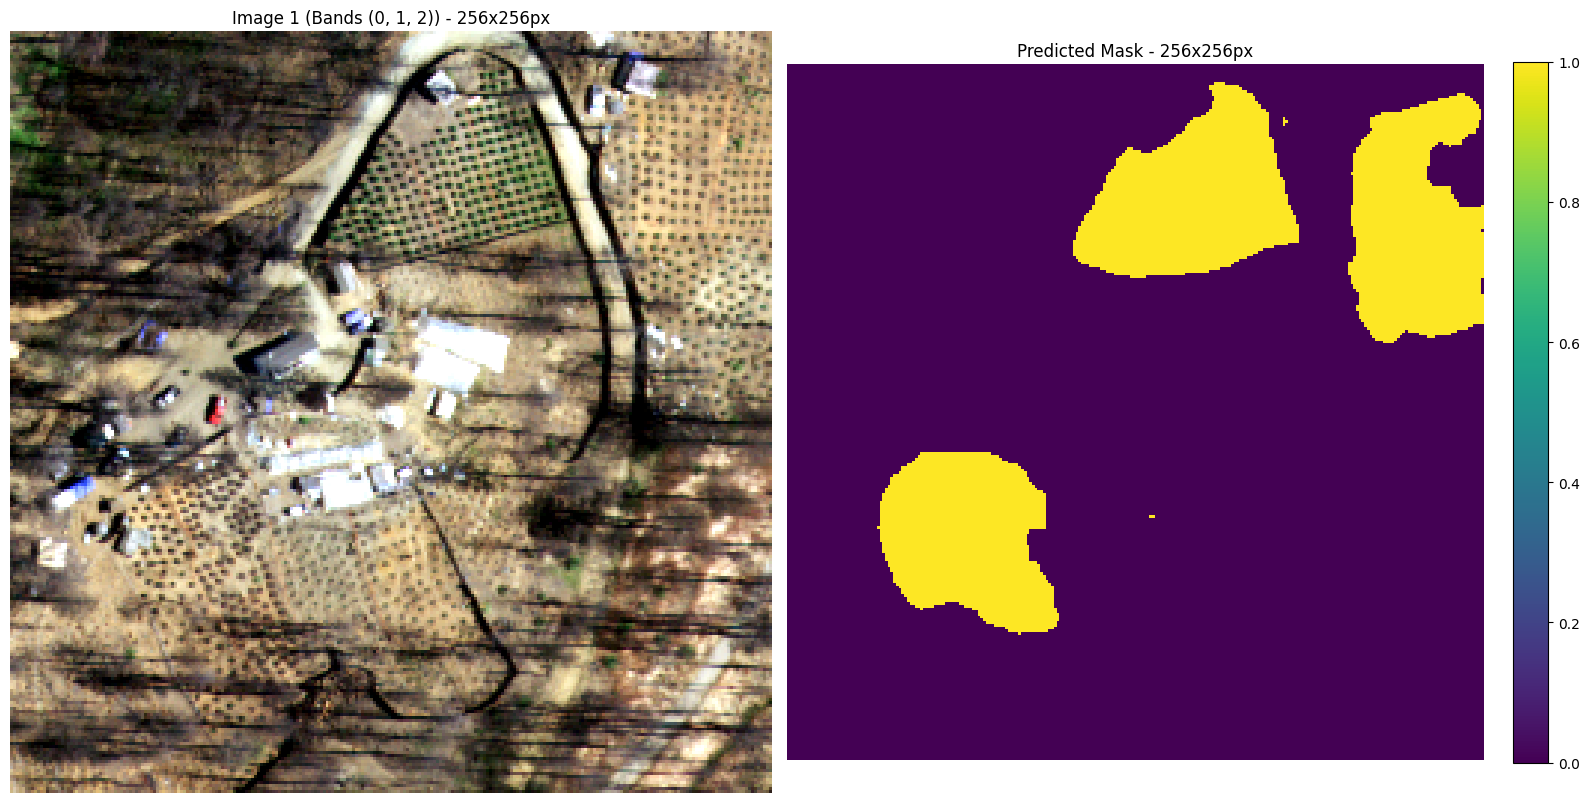

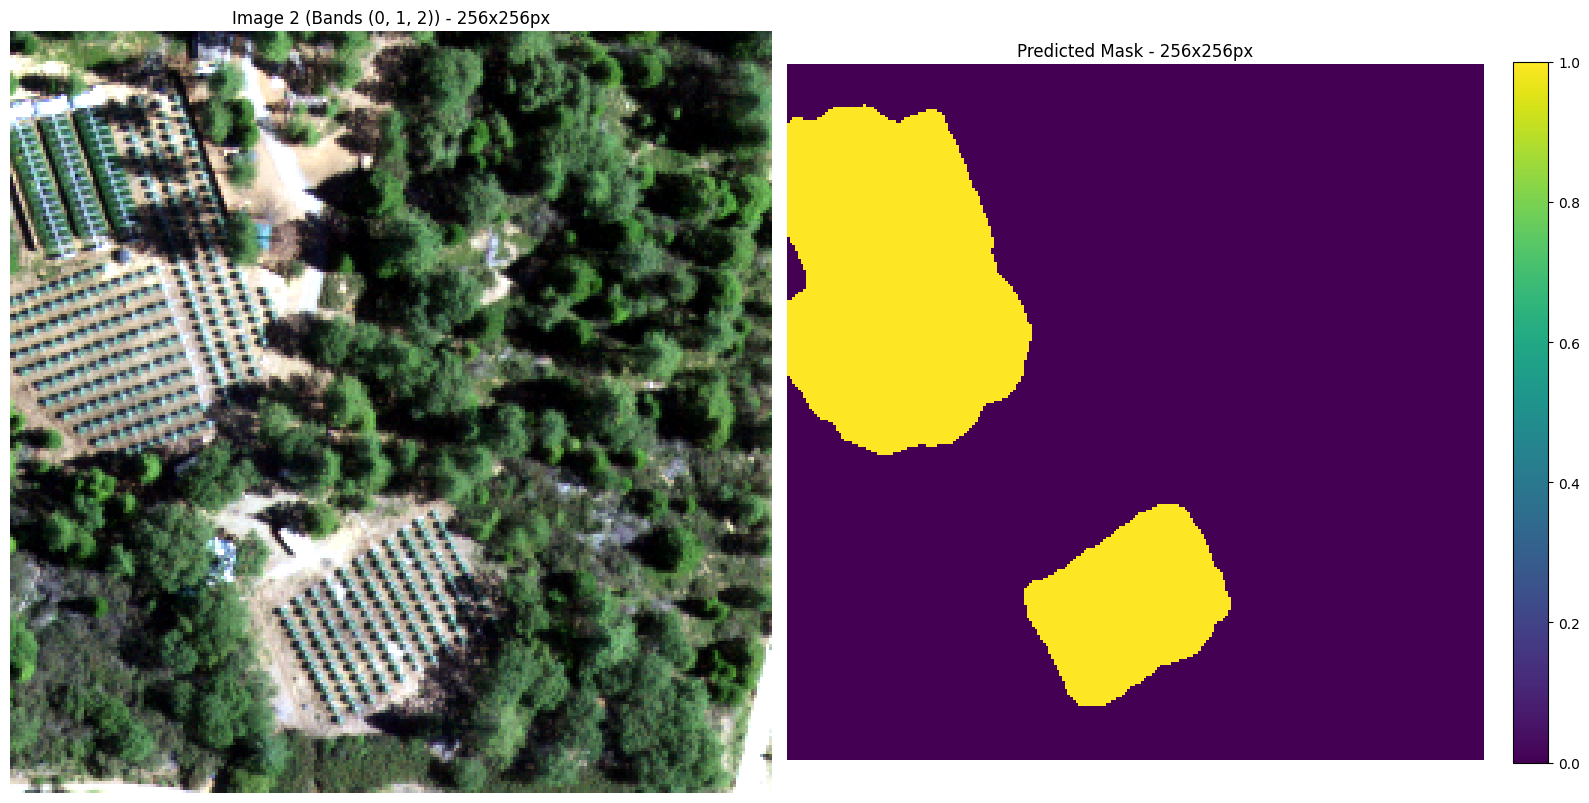

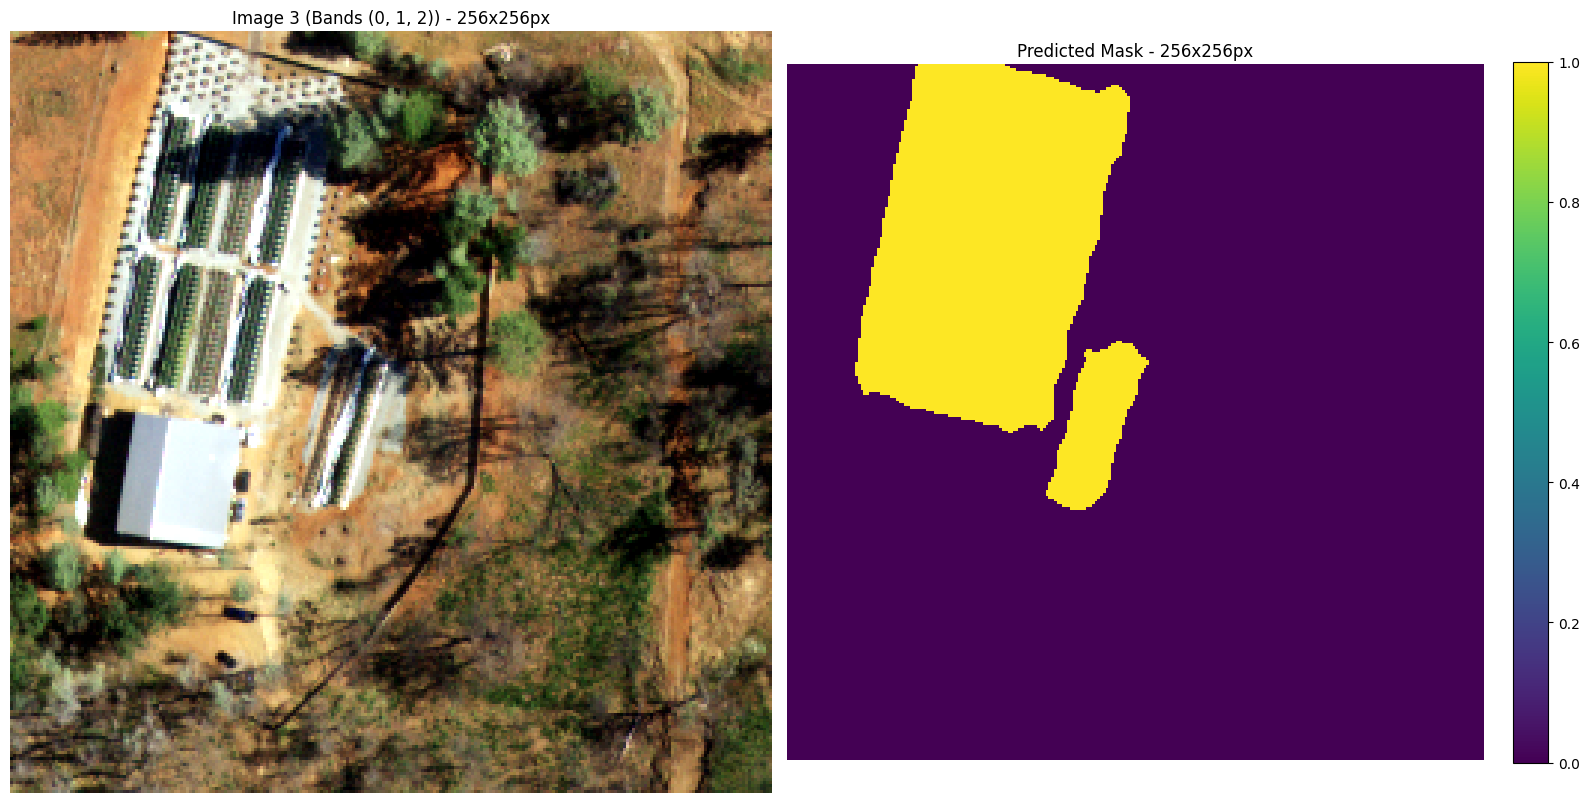

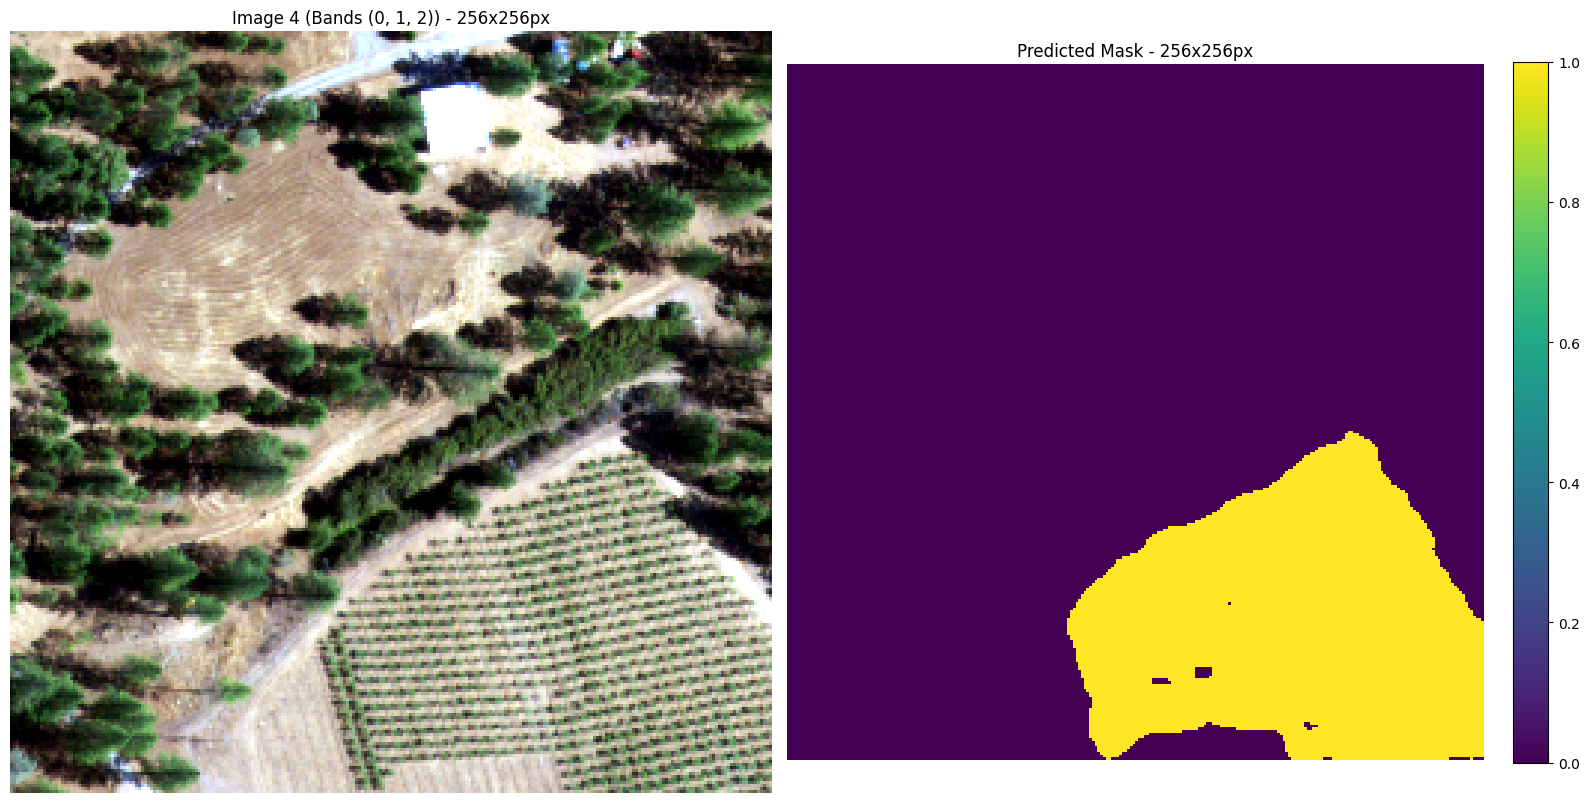

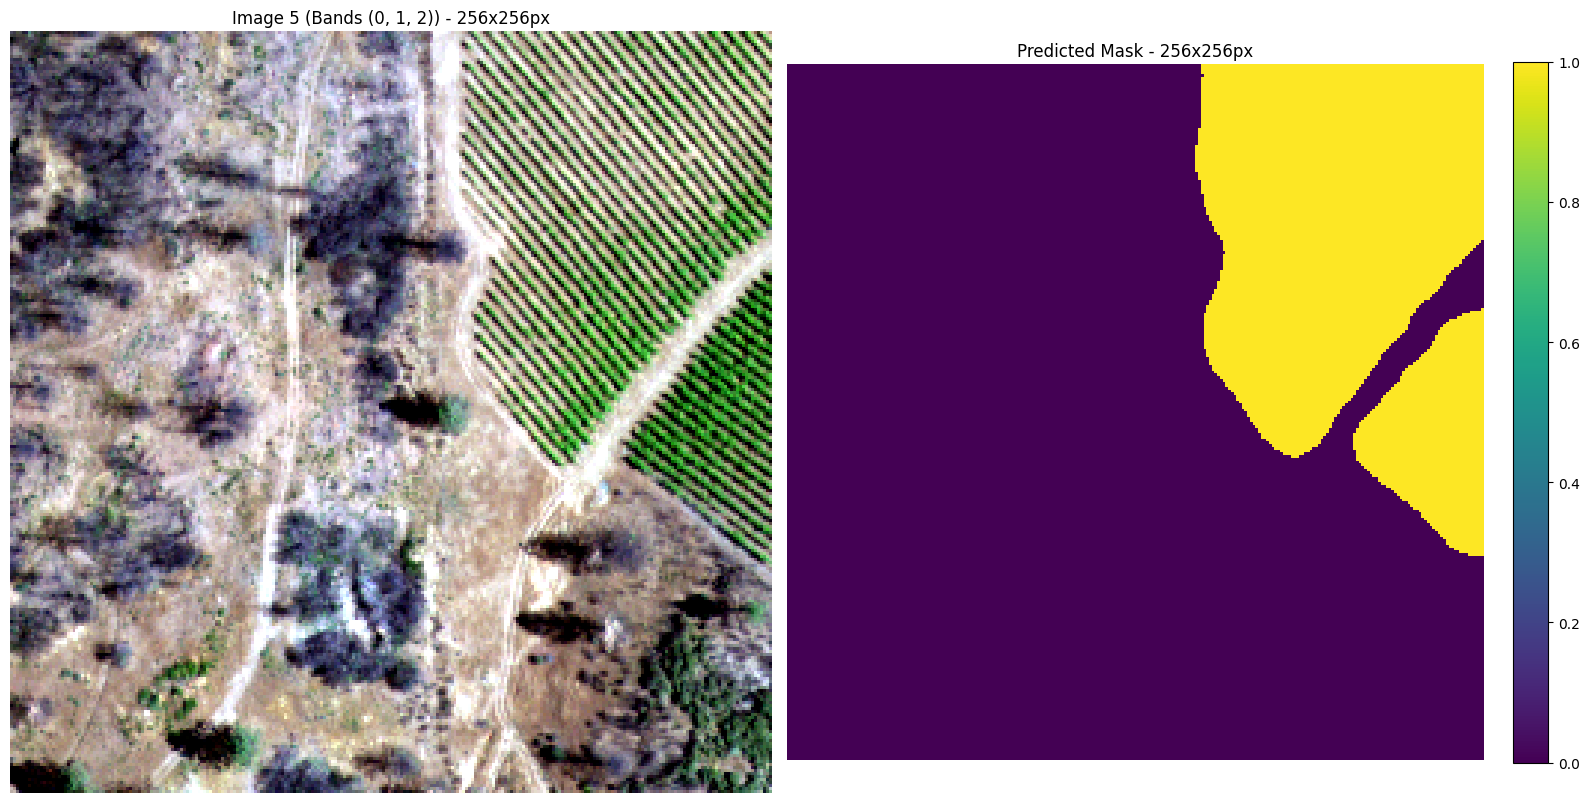

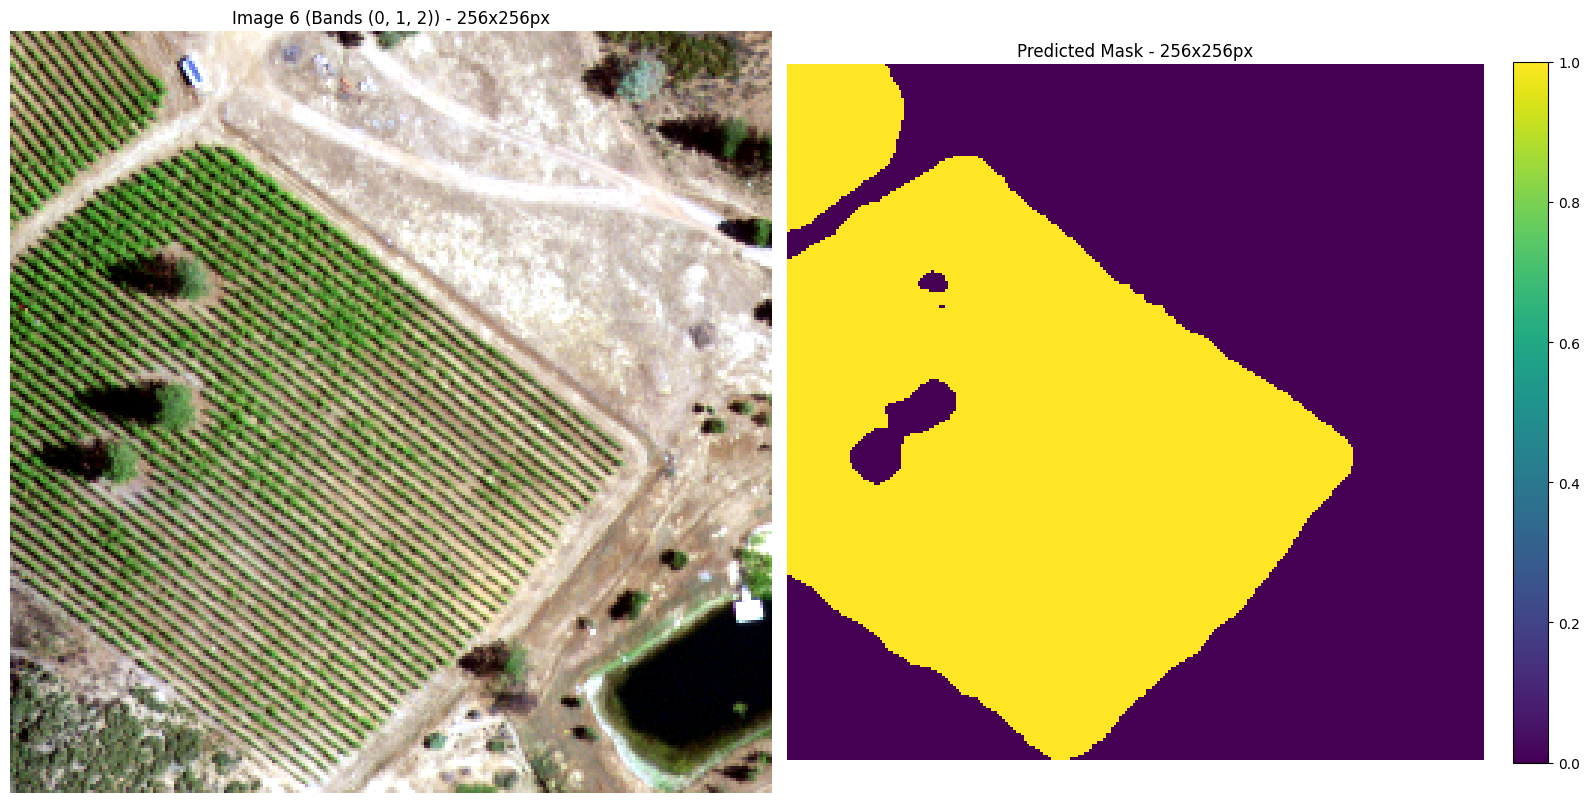

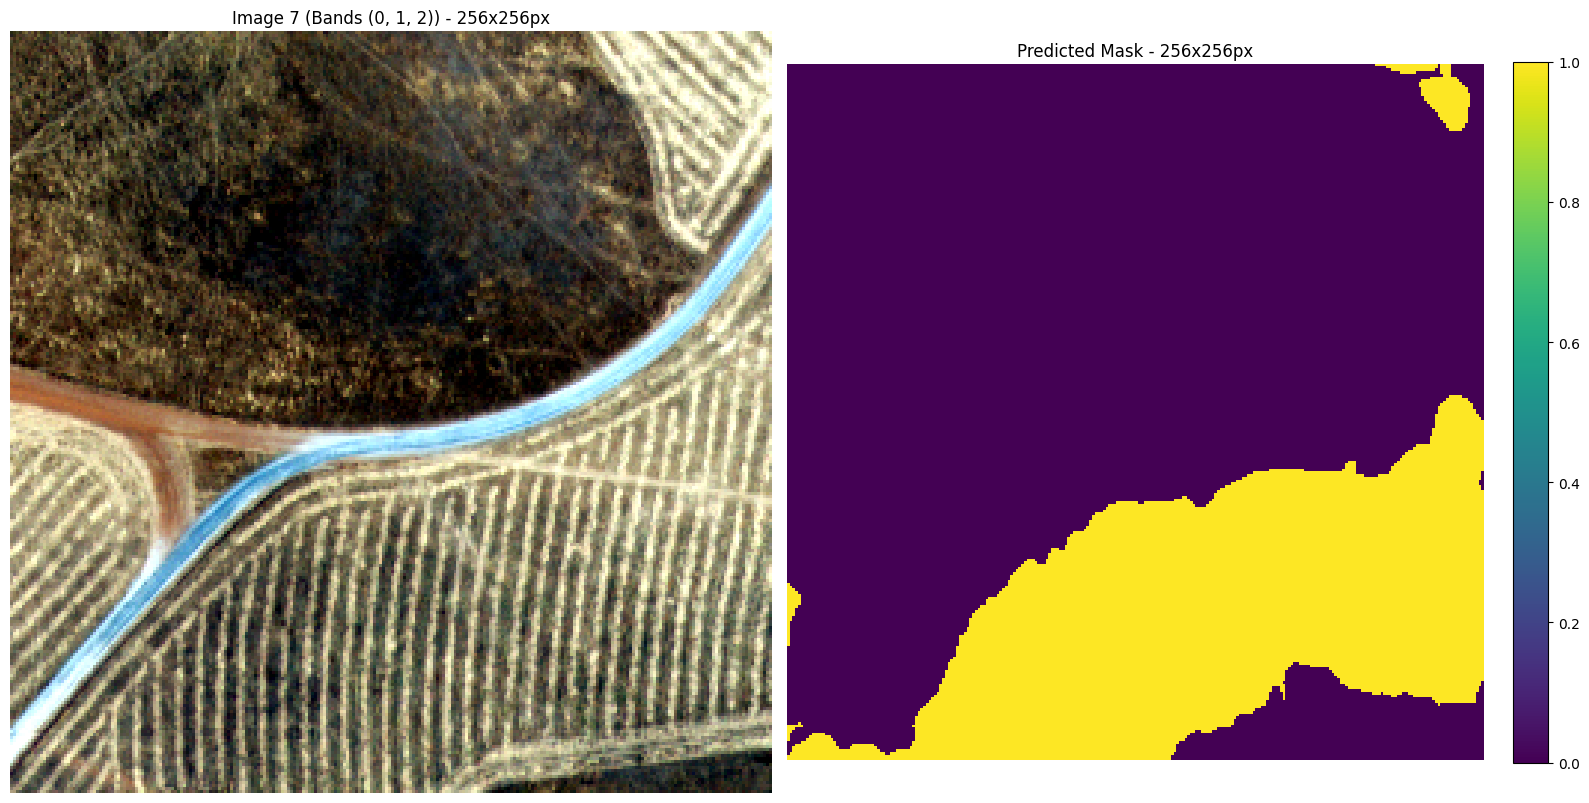

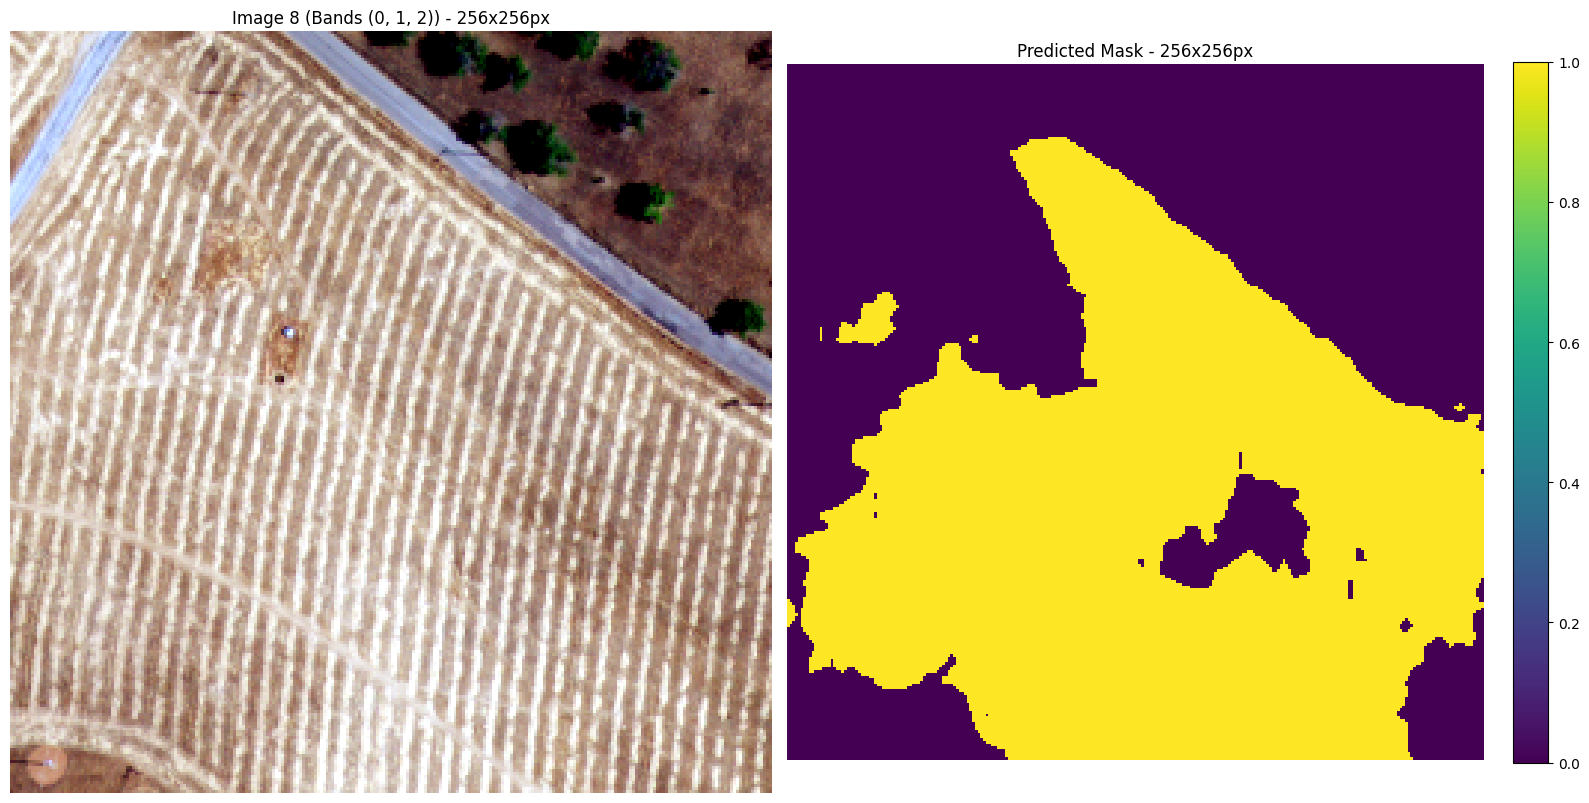

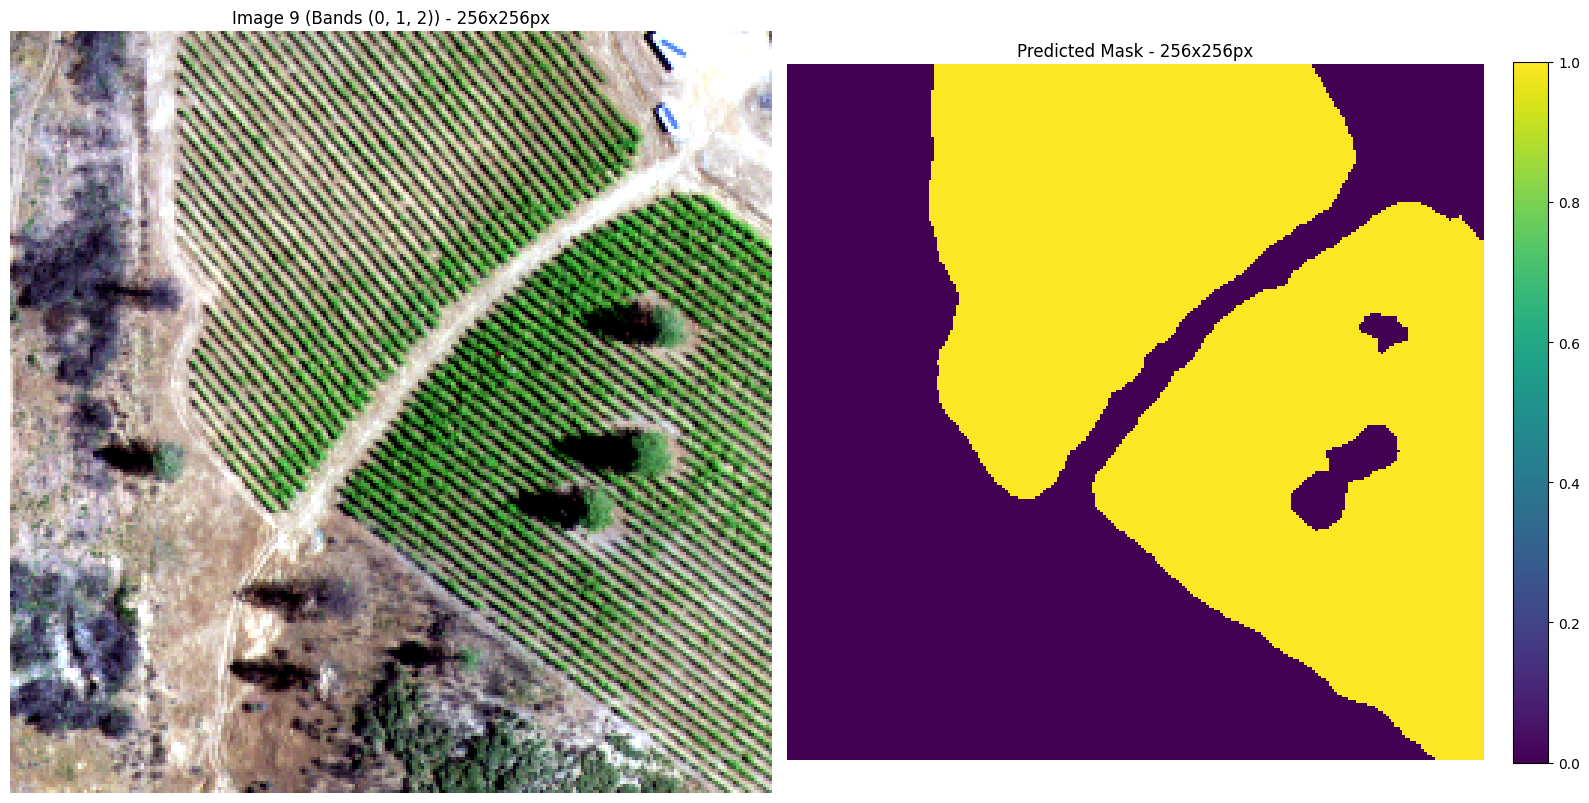

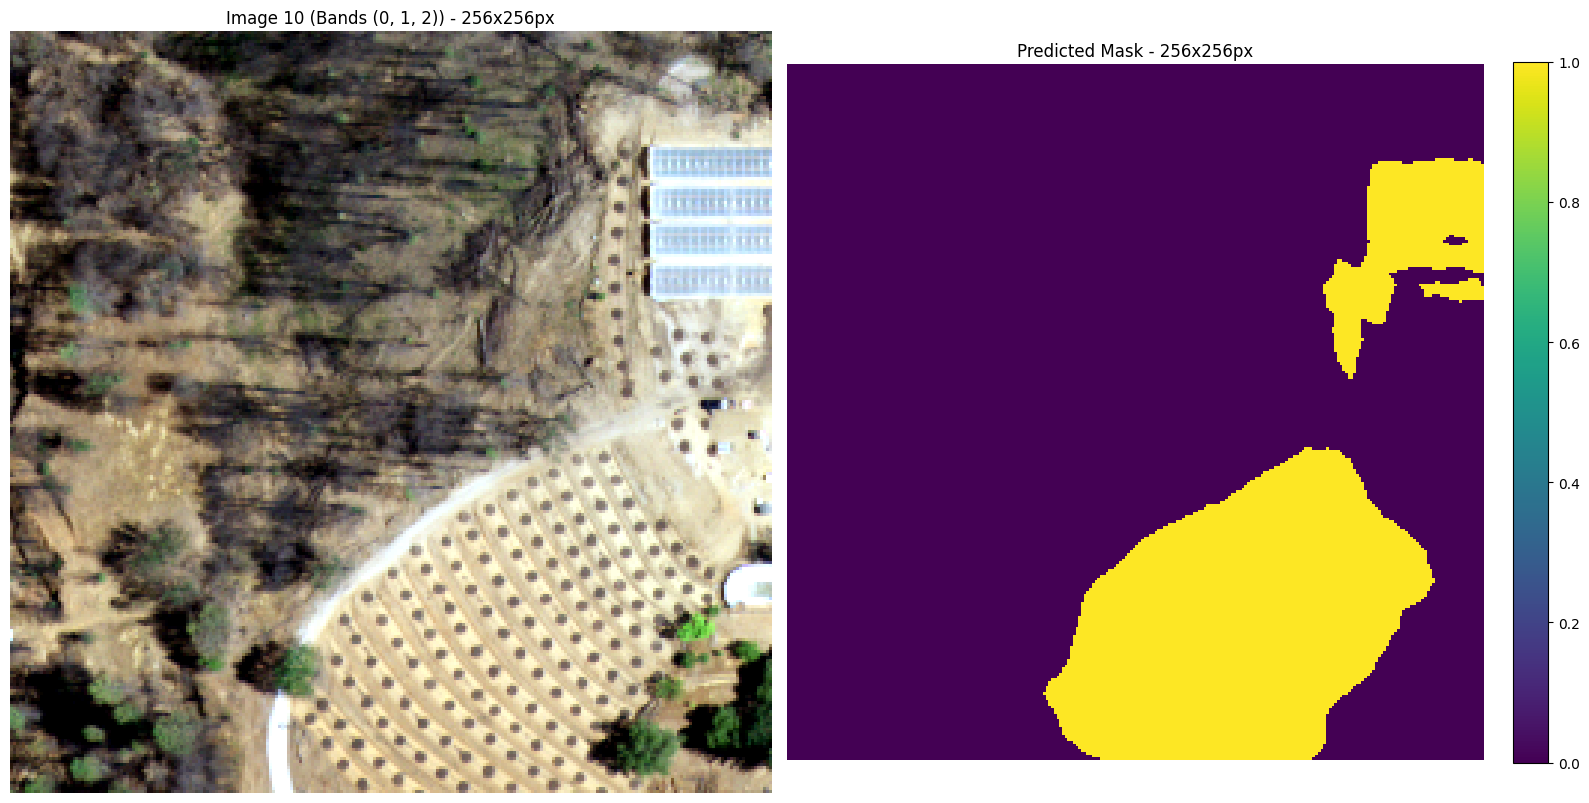

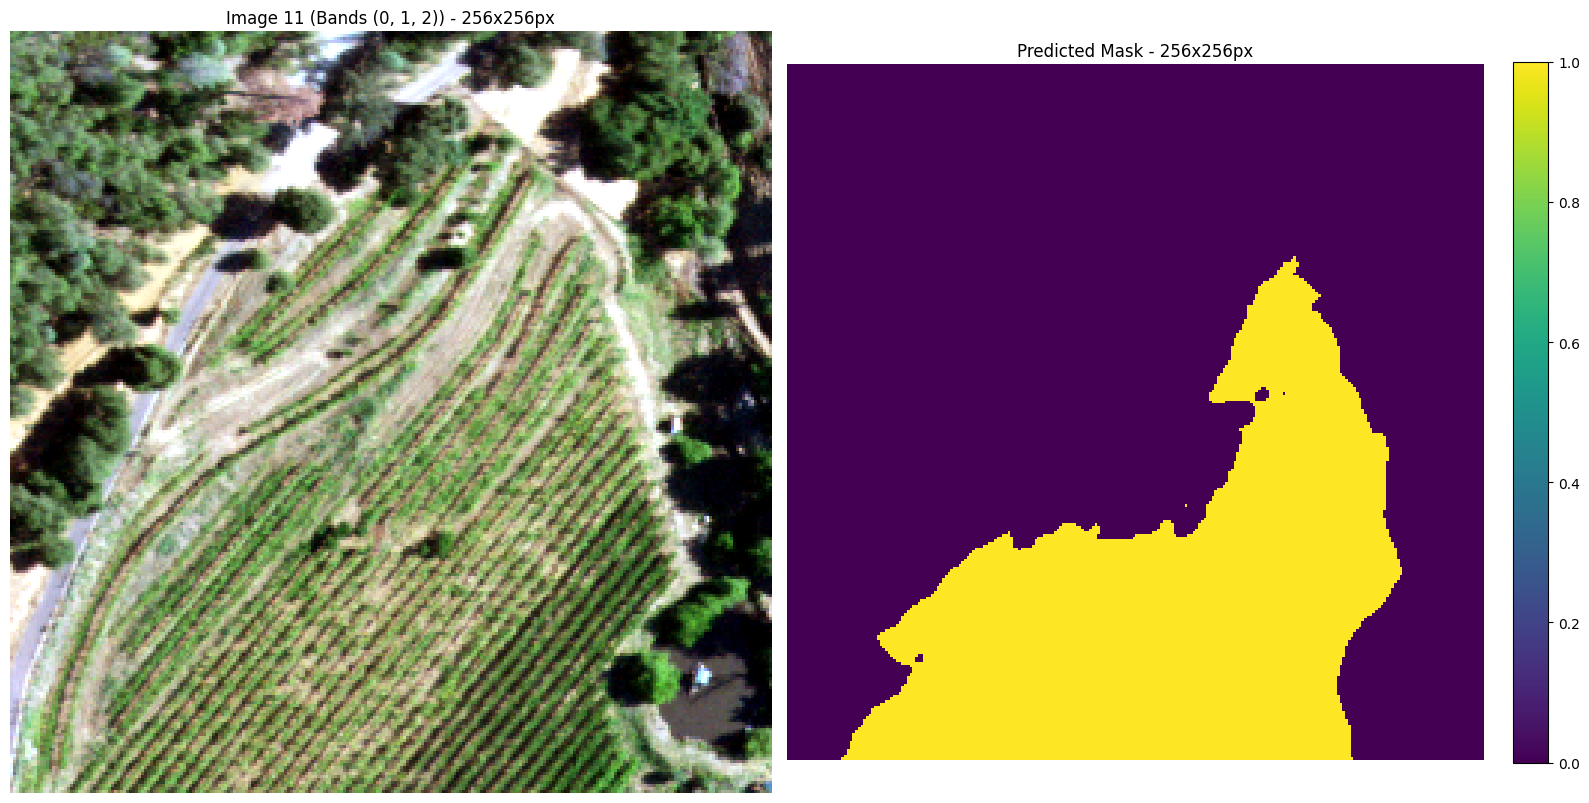

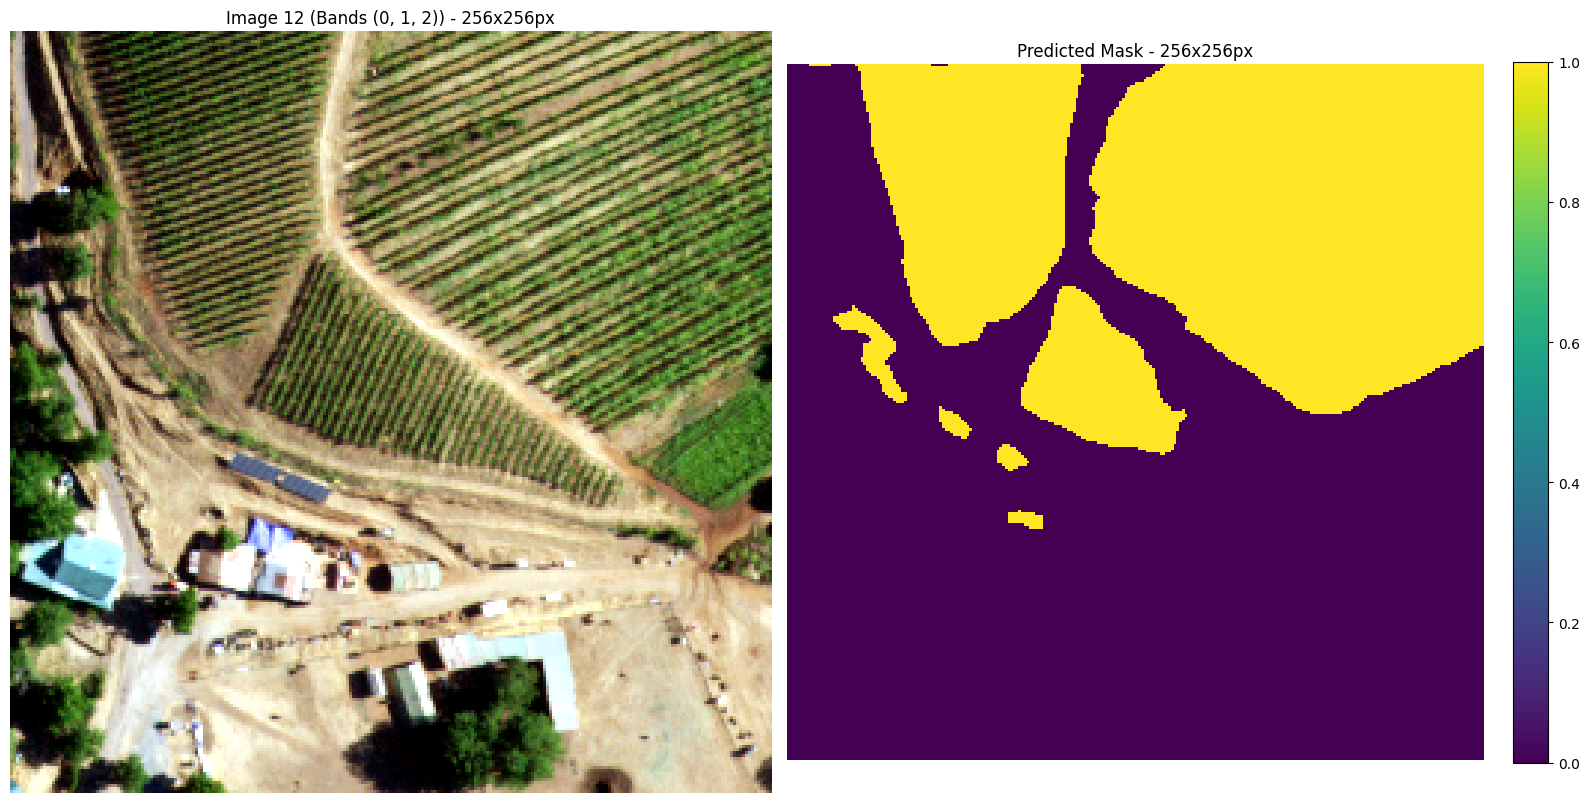

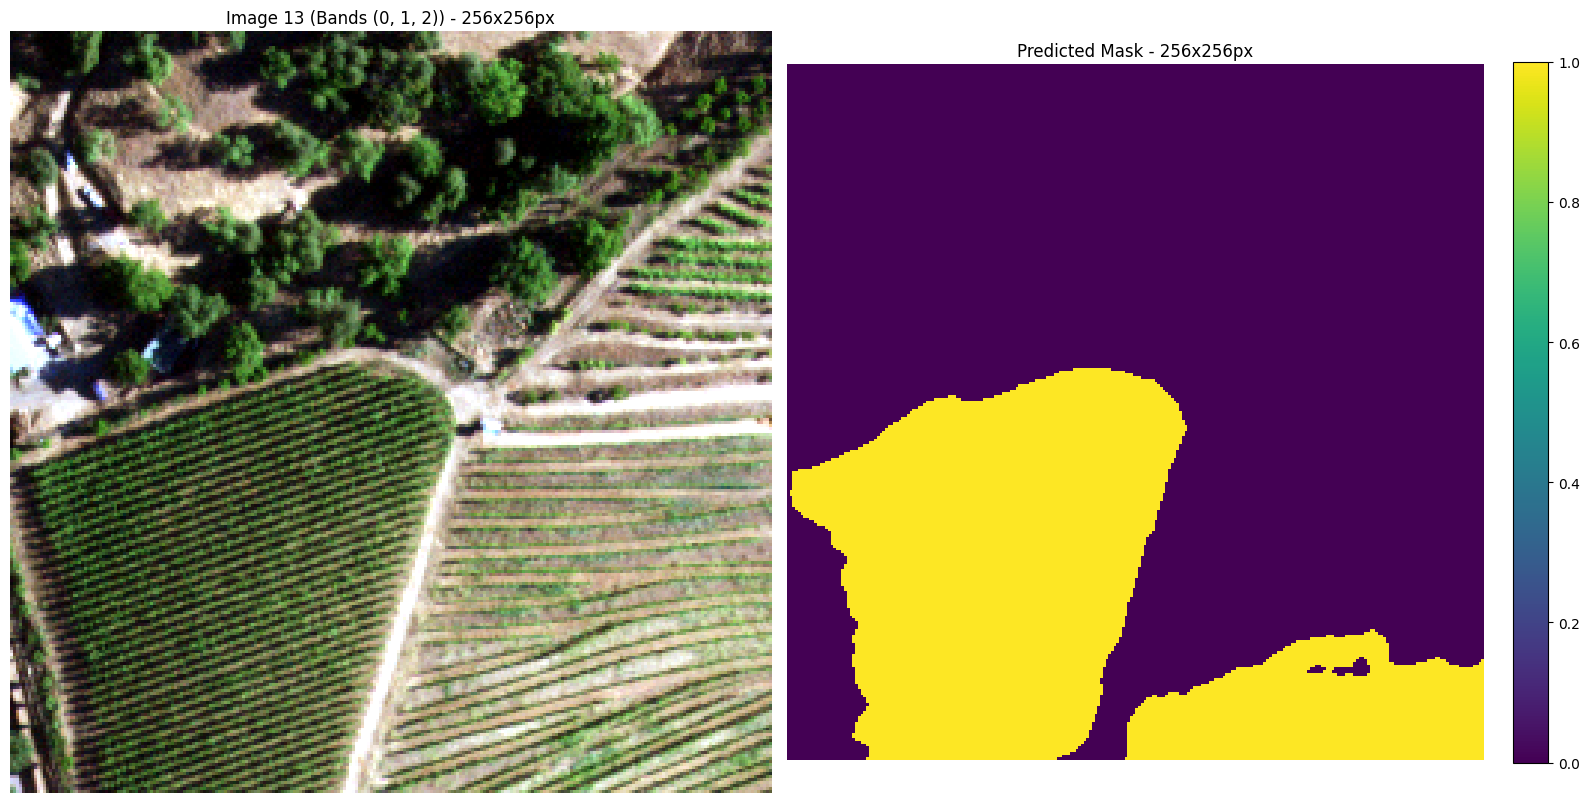

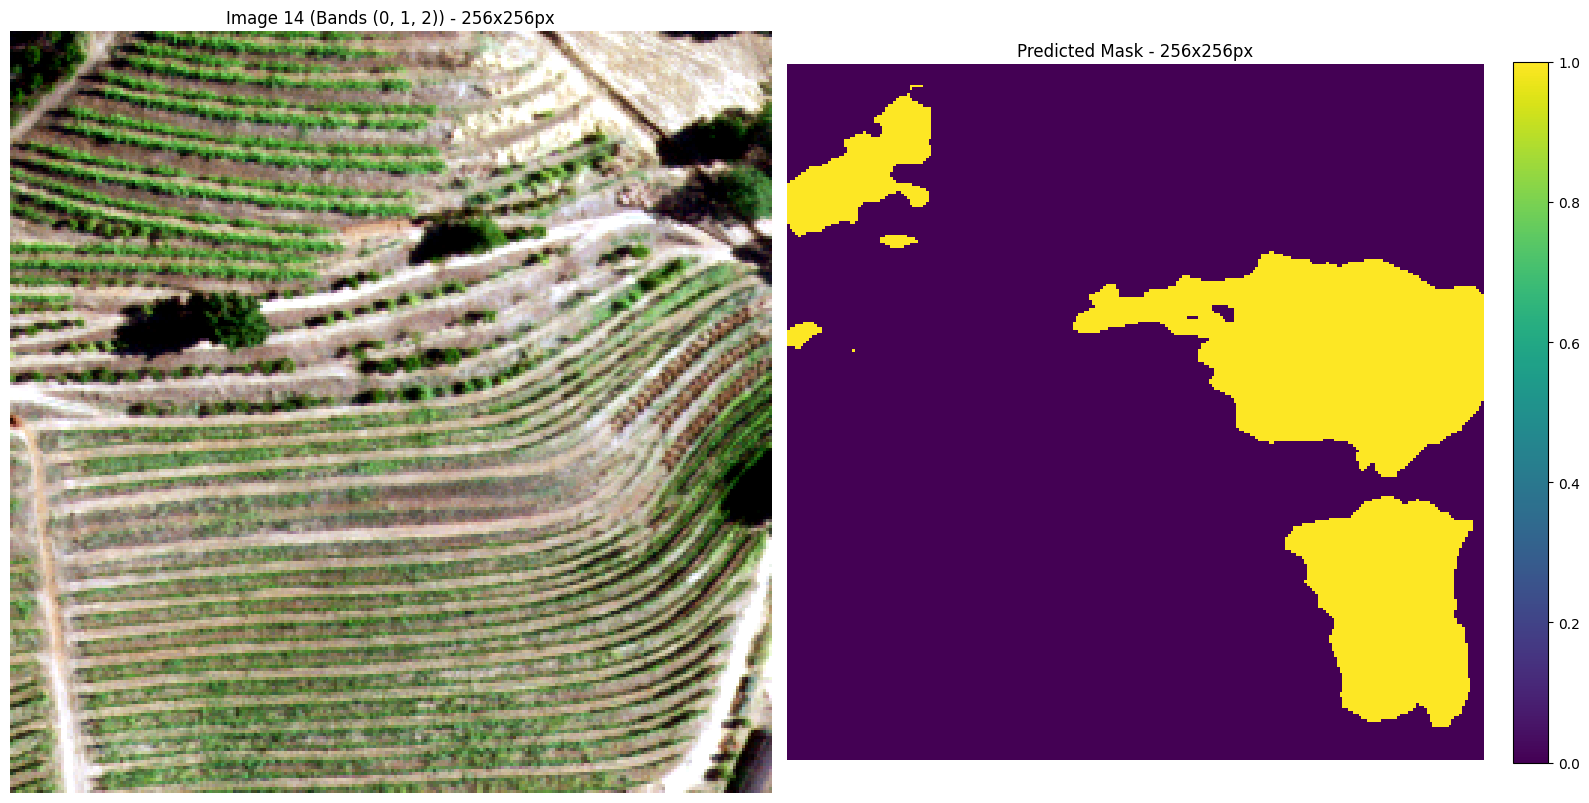

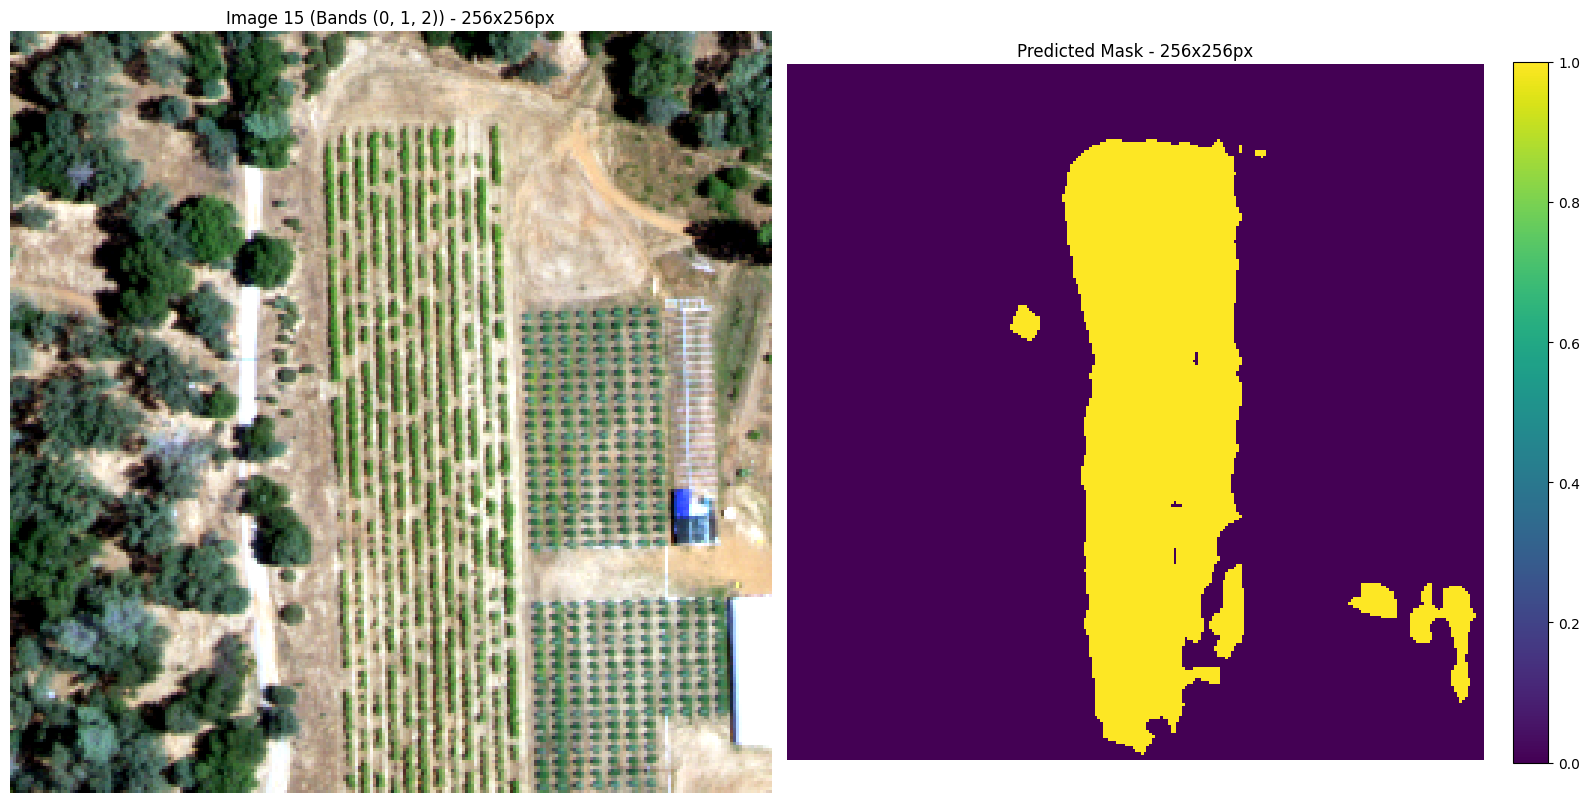

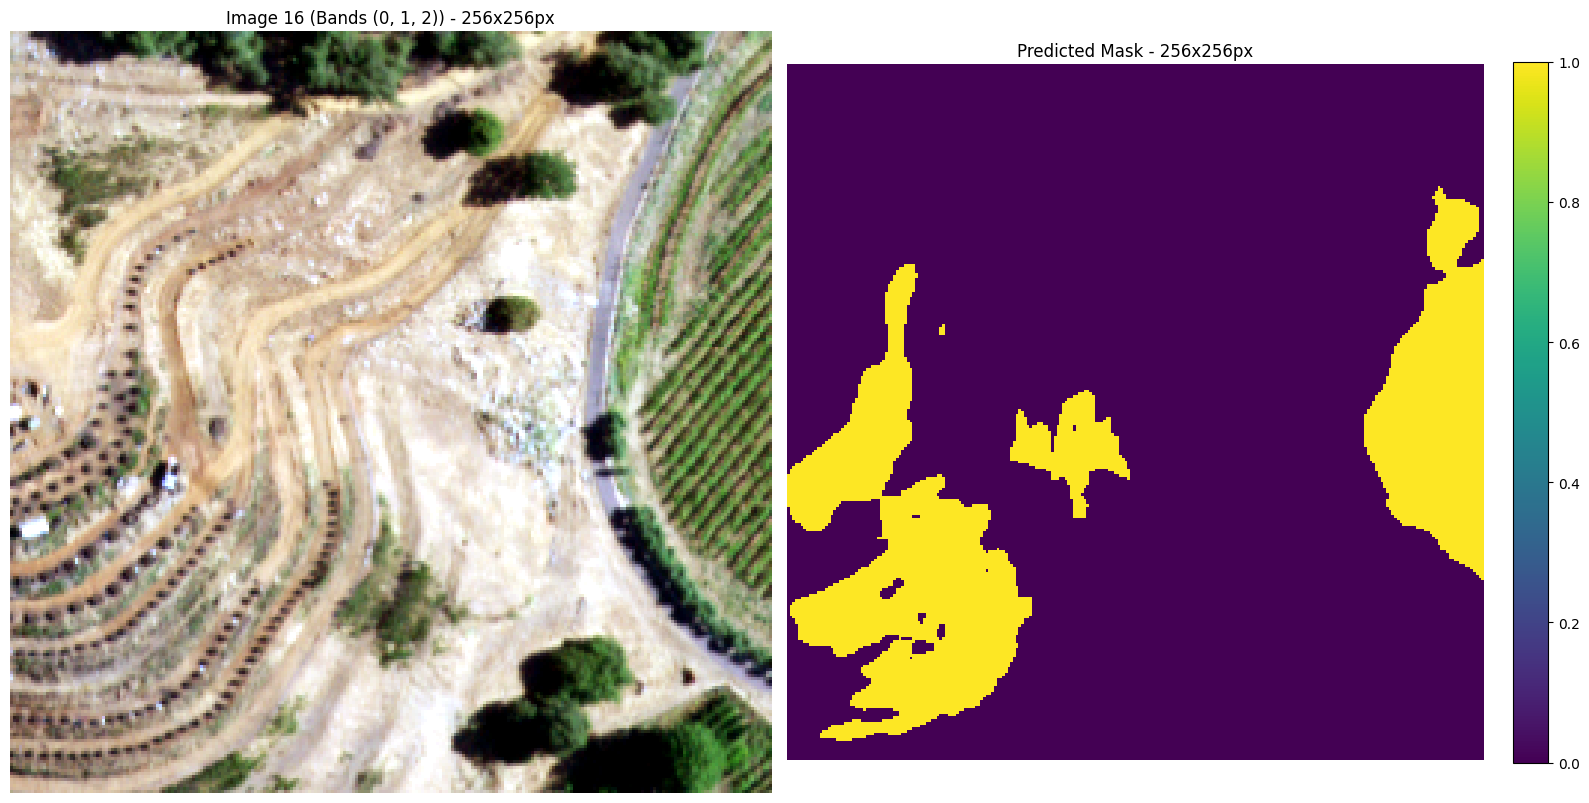

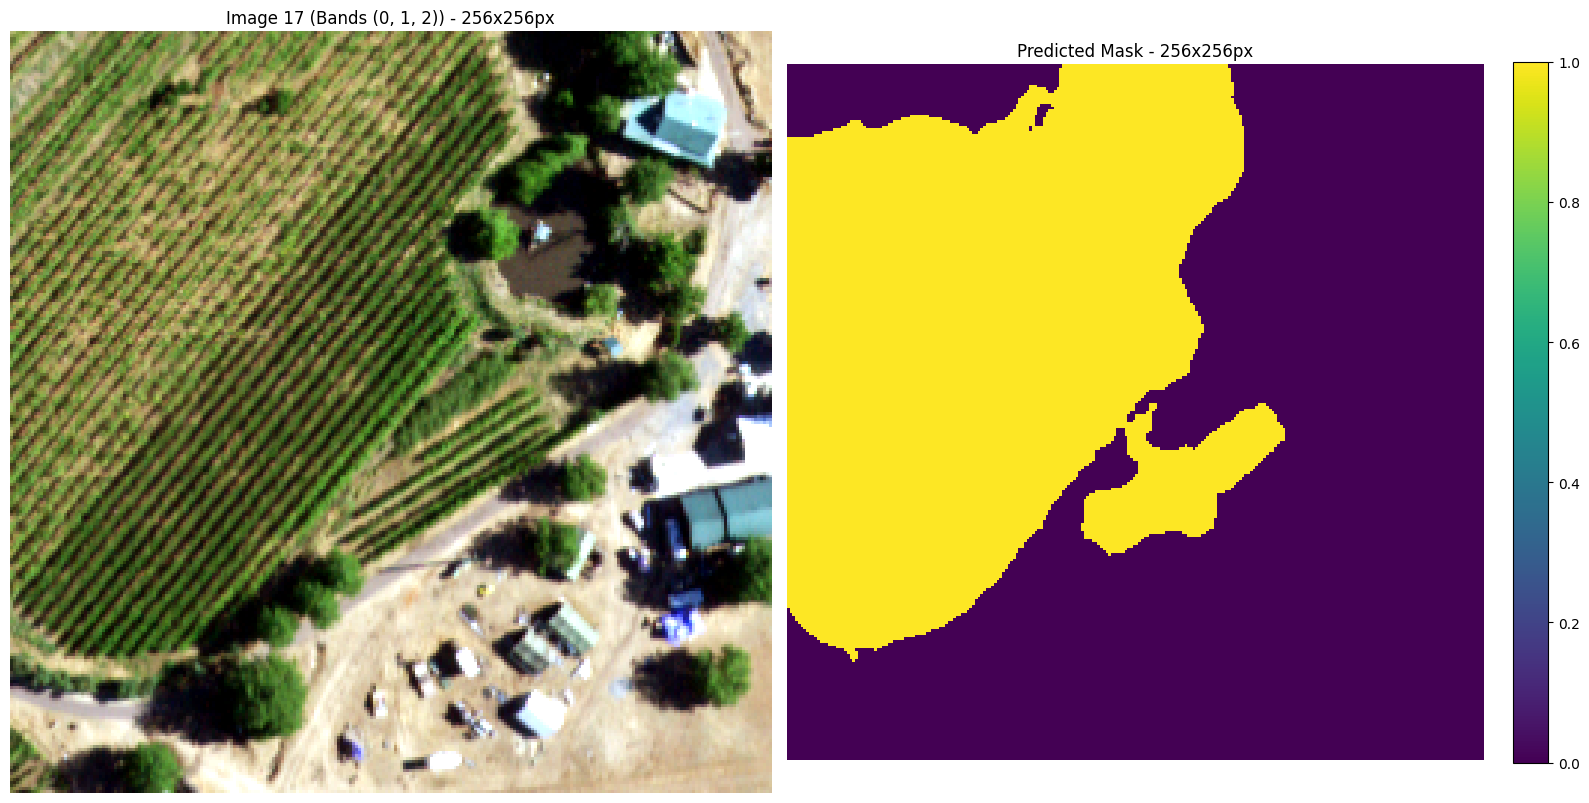

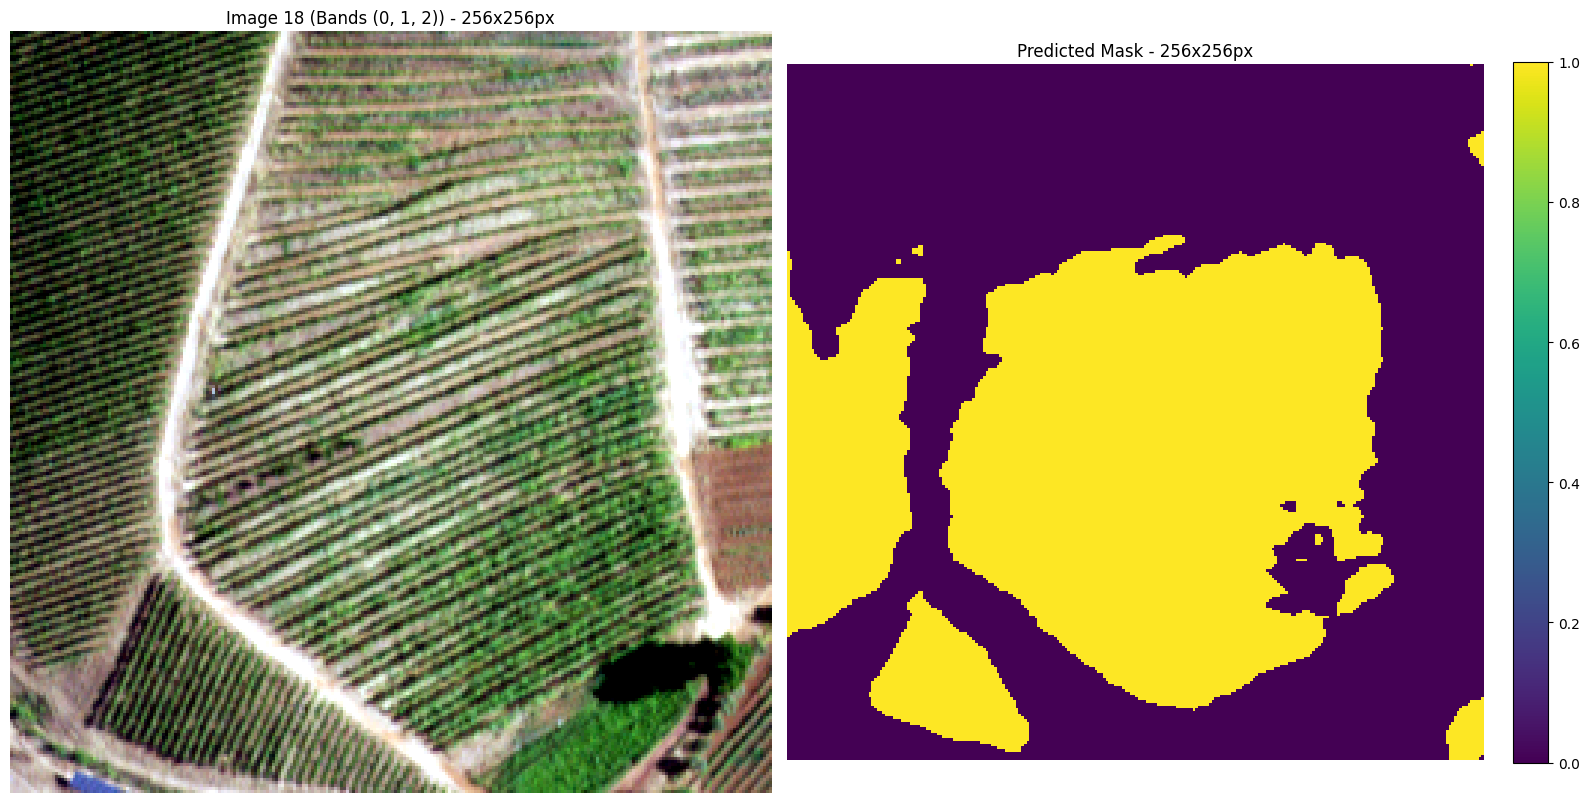

In [15]:
# Visualize top detections (memory efficient - only loads selected images)
significant_results = visualize_top_detections(
    detection_results,       # Results from stream_inference
    dataloader,              # DataLoader to re-read images
    model,                   # Model
    device,                  # Device
    threshold=0.3,           # Binary threshold
    min_pixels=10000,          # Minimum pixels to consider significant
    max_visualizations=40,    # Max images to show
    show_all=False            # Show all images sorted by predictions
)